In [63]:
# 导入必要的包
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import copy
import time
import pandas as pd

In [ ]:
'''
产生初始解和初始目标函数X0和f0，初始化最优值记录器X*和f*

既然序列对可以表达模块的位置信息以及整体的最大长度和宽度
那么我们对模块进行乱序，随机生成一个序列对，一个正序列和一个负序列
目标函数就是该序列形成的矩形面积除以总面积，这样子就可以用求目标函数的最小值的方法求解该问题

while(不满足回火终止条件)
    t=t0
        while t>1e-3
            for i=0 i<L i++
                从四种新解中任选一种产生新解Xnew
                计算评价新解的目标函数fnew
                计算评价目标函数差df=fnew-f
                
                if df<0 or exp(-df/t)>random(0,1)
                    接受新解X=Xnew f=fnew
                    与最优值记录器比较，记录最优值
                else
                    还原原来的解
            下降温度 t=a*t
        以记录器的最优解作为下一个循环的初始解
    达不到要求，产生回火温度

'''

In [ ]:
'''
首先
    我们要确定初始温度T0和降温系数α还有终止温度Tf（决定了一共生成
    多少组新解、接受新解的程度）、迭代次数iter（生成一批新解中的新
    解的个数）。
评价函数设置
    整体面积利用率的倒数，一般模拟退火算法都是对最小值进行求解的，
    于是我们需要的面积利用率越大越好，所以我们取倒数即可。
    （面积利用率=sum(模块面积)/生成的矩形画布的面积，生成的矩形画
    布的面积我们可以通过求解LCS得到）

伪代码：
生成初始解x&y&h&w
while T(当前温度)>Tf
    while n(当前循环次数)<iter
        得到上一次的解或者是初始解x&y&h&w
            得到上一次解的评价函数的值f
        从四种方法中生成新解x_new&y_new&h_new&w_new
            得到评价函数值f_new
        Metropolis（f,f_new）  #Metropolis准则
            根据Metropolis准则的结果来决定是否接受新解或者是还原原来的解
    下降温度T=α*T
以记录器中的最优解作为布局问题的最终解


'''

In [26]:
class module():
    def __init__(self, name='', typ='', w=0., h=0., pos=[], s=0.):
        self.name = name  #模块名称
        self.typ = typ    #模块类型
        self.w = w        #模块宽度
        self.h = h        #模块高度
        self.pos = pos    #模块位置:右下角、右上角、左上角、左下角(左下角一般为(0,0))
        self.s = s        #模块面积

In [27]:
def rdfile(filename,n):
    #filename是要读取的文件名，n为其中所包含的模块数
    
    #用于存储所有模块对象的列表
    modules = np.zeros(n-1,dtype=type(module('a','b',0.,0.,[],0.))) 
    t = 0
    s_total = 0.
    b1,b2 = 0,0

    #通过文件名打开数据流，按照行的顺序有规律地依次将模块名...读出，顺便创建模块对象放入数组中方便调用
    with open(filename,'r') as f:
        for line in f:
            line = line.split(' ')
            if 'MODULE' in line:
                #print(line[1].split(';')[0])
                name = line[1].split(';')[0]

            if 'TYPE' in line:
                typ = line[2]

            if 'DIMENSIONS' in line:
                #print(line[2:])
                w = 0.
                h = 0.
                pos = np.zeros(8)
                for i in range(10)[2:]:
                    if i != 9:
                        pos[i-2] = int(line[i])
                    else:
                        pos[i-2] = int(line[i].split(";")[0])
                # 用两个坐标值相减即可得到模块的宽高
                h = pos[3]-pos[1]
                w = pos[2]-pos[4]
                s = h*w
                if t == n-1:
                    # 这里的s是parent模块的面积，其实实际上并没有使用到
                    s_total = s
                if t<n-1:
                    modules[t] = module(name,typ,w,h,pos,s)
                    t = t+1
                
    return modules,s_total

In [28]:
# 读取ami33和ami49并计算出它们模块的总面积（不包括parent）
modules,st = rdfile('ami33.yal',34)
modules1,st1 = rdfile('ami49.yal',50)
s = 0.
for i in range(33):
    s = s + modules[i].s
s1 = 0.
for i in range(49):
    s1 = s1 + modules1[i].s
print(s,s1)

1156449.0 35445424.0


In [38]:
# m类，用于存储一组模块的布局
# x为正向序列，y为负向序列，modules则存储着从文件读取出来的各个模块的信息，比如宽w和高h
# m类中还存储着这组模块布局所代表的信息比如面积利用率use、总面积s_cur...其中的iuse是用于模拟退火算法，它是面积利用率的倒数
class m():
    def __init__(self, modules,s_total):
        self.modules = modules
        self.s_total = s_total
        self.l = len(modules)
        self.s_cur,self.iuse,self.use = 0.,0.,0.
        
        # 产生一个比较优的解，在此基础上进行模拟退火，这里随机产生可能没有对模块进行旋转
        # 可能在一定程度上会导致我们的初始解较差
        self.x,self.y,self.modules = self.xyInit()
        self.w,self.h = m.whSort(self.l, self.x, self.y, self.modules)
        self.s_cur,self.iuse,self.use = m.calSC(self.l, self.x, self.y, self.w, self.h, self.s_total) 

    # 计算当前模块布局的信息：总面积s_cur、面积利用率及其倒数
    def calSC(l,x,y,w,h,s_total):
        Lw,Pw,Lh,Ph = m.lcs_xy(l,x,y,w,h)
        s_cur = Lw*Lh
        iuse = s_cur/s_total
        use = s_total/s_cur
            
        return s_cur,iuse,use
    
    # 根据x和y序列还有模块序列（包含旋转信息），来生成新的模块宽高序列，用于LCS算法
    def whSort(l,x,y,modules):
        w = np.zeros(l)
        h = np.zeros(l)
        for i in range(l):
            w[i] = modules[i].w
            h[i] = modules[i].h
        return w,h
    
    # 初始化生成一组正向和反向序列--生成一个0到（总模块个数-1）长度的顺序序列，然后用shuffle打乱，随机翻转模块
    def xyInit(self):
        l = self.l
        tmp = np.zeros(l,dtype='int')
        for i in range(l):
            tmp[i] = i
            
        np.random.shuffle(tmp)
        x = copy.deepcopy(tmp)
        np.random.shuffle(tmp)
        y = copy.deepcopy(tmp)
        
        # 模块随机翻转
        md = copy.deepcopy(self.modules)
        for i in range(l):
            yes = random.randint(0,1)
            if yes:
                md[i].w,md[i].h = md[i].h,md[i].w 
            
        return x,y,md
    
    # lcs快速算法
    def lcs_xy(n,x,y,w,h):
        xr = x[::-1]
        Lw,Pw = m.lcs(n,x,y,w)
        Lh,Ph = m.lcs(n,xr,y,h)
        return Lw,Pw,Lh,Ph
    
    # lcs快速算法核心
    def lcs(n,x,y,w):
        # n个模块，x为正序列，y为负序列，w为每个模块的宽度/高度 
        class mdd():
            def __init__(self,x,y):
                self.x = x
                self.y = y

        match = np.zeros(n,dtype=type(mdd(3,4)))
        for i in range(len(x)):
            for j in range(len(y)):
                if x[i]==y[j]:
                    match[int(x[i]-1)] = mdd(i,j)
                    break
                    
        # 模块的位置P，总长度L
        P = np.zeros(n)
        L = np.zeros(n)

        for i in range(n):
            b = int(x[i]-1)
            p = int(match[b].y)
            P[b] = L[p]
            t = P[b] + w[b]
            for j in range(n)[p:n]:
                if t > L[j]:
                    L[j] = t
                else:
                    break

        return L[n-1],P
    
    def refresh(self):
        # 由于x,y,modules的改变，需要更新数据
        self.w,self.h = m.whSort(self.l, self.x, self.y, self.modules)
        self.s_cur,self.iuse,self.use = m.calSC(self.l, self.x, self.y, self.w, self.h, self.s_total) 
    
    def exchangeX(self,pos1,pos2):
        # 第1个随机模块与第2个随机模块交换正序列中的位置
        id1 = np.array(np.where(self.x==pos1))[0][0]
        id2 = np.array(np.where(self.x==pos2))[0][0] 
        x1 = copy.deepcopy(self.x)
        x1[id1],x1[id2] = x1[id2],x1[id1]
        self.x = x1
        return
    
    def exchangeY(self,pos1,pos2):
        # 第1个随机模块与第2个随机模块交换负序列中的位置
        id1 = np.array(np.where(self.y==pos1))[0][0]
        id2 = np.array(np.where(self.y==pos2))[0][0]
        y1 = copy.deepcopy(self.y)
        y1[id1],y1[id2] = y1[id2],y1[id1]
        self.y = y1
        return
    
    def exchangeXY(self,pos1,pos2):
        # 第1个随机模块与第2个随机模块交换正负序列中的位置
        self.exchangeX(pos1,pos2)
        self.exchangeY(pos1,pos2)
        return
    
    def exchangeWH(self,pos):
        # 旋转模块
        md = copy.deepcopy(self.modules)
        md[pos].w,md[pos].h = md[pos].h,md[pos].w 
        self.modules = md
        return
       
        

In [32]:
# SA类 进行模拟退火算法的框架
# 包含3个主要的方法：产生新解、Metropolis准则、运行
class SA:
    def __init__(self, m1, m2, m3, s_total, iter=4000, T0=400, Tf=0.01, alpha=0.95):
        self.iter = iter         #内循环迭代次数,即为L =100
        self.alpha = alpha       #降温系数，alpha=0.95
        self.T0 = T0             #初始温度T0为400
        self.Tf = Tf             #温度终值Tf为0.01
        self.T = T0              #当前温度
        
        # 生成初始解
        self.m1 = m1
        # 用于保存局部最优解&全局最优解
        self.m2 = m2
        self.m3 = m3
        
        # 模块的一些相关信息，模块个数&模块总面积
        self.l = self.m1.l
        self.s_total = self.m1.s_total
        
        # 存放解的序列对
        self.xi = np.zeros((self.iter,self.l),dtype='int')
        self.yi = np.zeros((self.iter,self.l),dtype='int')
        self.modulesi = np.zeros((self.iter,self.l),dtype=type(module()))
                                 
        # 存放f的历史，用于生成图像
        self.history = {'f': [], 'T': []}

    def generate_new(self):   #扰动产生新解的过程
        rand,rand1,rand2 = 0,0,0
        # 选择产生新解的方式
        rand = random.randint(1,4)
        
        while rand1 == rand2:
            rand1 = random.randint(0,self.l-1)
            rand2 = random.randint(0,self.l-1)
            
        if rand == 1:
            #正向序列中交换两个模块的顺序
            self.m1.exchangeX(rand1,rand2)
        elif rand == 2:
            #负向序列中交换两个模块的顺序
            self.m1.exchangeY(rand1,rand2)
        elif rand == 3:
            #正向序列和负向序列中同时交换两个模块的顺序
            self.m1.exchangeXY(rand1,rand2)
        else:
            #将某个模块旋转，即将模块中的宽和高对调
            self.m1.exchangeWH(rand1)
            
        self.m1.refresh()
            
        return 

    def Metrospolis(self, f, f_new):   #Metropolis准则
        if f_new <= f:
            if self.m1.iuse < self.m3.iuse:
                self.m3.x,self.m3.y,self.m3.modules = copy.deepcopy(self.m1.x),copy.deepcopy(self.m1.y),copy.deepcopy(self.m1.modules)
                self.m3.refresh()
            return 1
        else:
            p = math.exp((f - f_new) / self.T)
            if np.random.rand() < p:
                return 1
            else:
                return 0

    
    def run(self):
        count = 0   #迭代计数器
        count1 = 0  #回火计数器
        
        #外循环迭代，当前温度小于终止温度的阈值
        while self.T > self.Tf:  
            #用于存放一次迭代的中间结果
            t= []   
            #内循环迭代
            for i in range(self.iter): 
                #f为迭代一次后的值
                f = self.m2.iuse
                #产生新解
                self.generate_new()
                x_new,y_new,modules_new = copy.deepcopy(self.m1.x),copy.deepcopy(self.m1.y),copy.deepcopy(self.m1.modules)
                #产生新值
                f_new = self.m1.iuse
                #判断是否接受新值
                if self.Metrospolis(f, f_new):
                    self.xi[i] = x_new
                    self.yi[i] = y_new
                    self.modulesi[i] = modules_new
                    t.append(f_new)
                else:
                    t.append(self.m1.iuse)
                    if i>= 1:
                        self.m1.x = copy.deepcopy(self.xi[i-1])
                        self.m1.y = copy.deepcopy(self.yi[i-1])
                        self.m1.modules = copy.deepcopy(self.modulesi[i-1])
                        self.m1.refresh()
            
                    
            f_best = min(t)
            idx = t.index(f_best)
            
            # 将当前局部最优解作为下一次迭代的初始解
            self.m1.x = copy.deepcopy(self.m3.x)
            self.m1.y = copy.deepcopy(self.m3.y)
            self.m1.modules = copy.deepcopy(self.m3.modules)
            self.m1.refresh()
            
            # 保存局部最优解，但是好像没用
            self.m2.x = copy.deepcopy(self.xi[idx])
            self.m2.y = copy.deepcopy(self.yi[idx])
            self.m2.modules = copy.deepcopy(self.modulesi[idx])
            self.m2.refresh()
            
            # 迭代L次记录在该温度下最优解
            self.history['f'].append(f_best)
            self.history['T'].append(self.T)
            
            #温度按照一定的比例下降（冷却）+回火
            self.T = self.T * self.alpha  
            #if self.T <= self.Tf:
                #if self.m3.use < 0.9:
                    #self.T = self.T0/2
                    #count1 += 1
                    #print("现在的结果好像不是很好，我的建议是回火！这是第" + str(count1) + "次回火")
                    
            count += 1
            
            print("第"+str(count)+"次迭代，局部最优结果为："+str(1/f_best))
            self.m3.refresh()
            print("当前最优结果:"+str(self.m3.use))
            
            
        return

In [ ]:
#mmm1 = []
#TTT1 = []
#fff1 = []
#sss1 = []

for i in range(10):
    t1 = time.time()
    m2 = m(modules,s)
    sa = SA(m1,m2,m3,s,Tf=0.005,alpha=0.98)
    sa.run()
    
    t2 = time.time()
    t = t2-t1
    mmm1.append(sa.m3)
    TTT1.append(sa.history['T'])
    fff1.append(sa.history['f'])
    sss1.append(t)
    print("本次退火用时："+str(t))
    if ms.use> sa.m3.use:
        m1 = copy.deepcopy(ms)
        m3 = copy.deepcopy(ms)
    else:
        m1 = copy.deepcopy(sa.m3)
        m3 = copy.deepcopy(sa.m3)
    


第1次迭代，局部最优结果为：0.5265729585006693
当前最优结果:0.9132100294072125
第2次迭代，局部最优结果为：0.7907062449745377
当前最优结果:0.9132100294072125
第3次迭代，局部最优结果为：0.7320863577144985
当前最优结果:0.9132100294072125
第4次迭代，局部最优结果为：0.8029189630536844
当前最优结果:0.9132100294072125
第5次迭代，局部最优结果为：0.9132100294072125
当前最优结果:0.9132100294072125
第6次迭代，局部最优结果为：0.8312552831783601
当前最优结果:0.9132100294072125
第7次迭代，局部最优结果为：0.7184474885844749
当前最优结果:0.9132100294072125
第8次迭代，局部最优结果为：0.6342138499986564
当前最优结果:0.9132100294072125
第9次迭代，局部最优结果为：0.6394721868480234
当前最优结果:0.9132100294072125
第10次迭代，局部最优结果为：0.6794391985260249
当前最优结果:0.9132100294072125
第11次迭代，局部最优结果为：0.7327682563338301
当前最优结果:0.9132100294072125
第12次迭代，局部最优结果为：0.7946464646464647
当前最优结果:0.9132100294072125
第13次迭代，局部最优结果为：0.7627989657401423
当前最优结果:0.9132100294072125
第14次迭代，局部最优结果为：0.7550628659180343
当前最优结果:0.9132100294072125
第15次迭代，局部最优结果为：0.559132906894101
当前最优结果:0.9132100294072125
第16次迭代，局部最优结果为：0.8420508063365206
当前最优结果:0.9132100294072125
第17次迭代，局部最优结果为：0.6186045292514154
当前最优结果:0.9132100

In [74]:
use = []
for i in range(len(mmm1)):
    use.append(mmm1[i].use)
print(use)
index = use.index(max(use))
ms = copy.deepcopy(mmm1[index])
print(ms.use)


[0.9132100294072125, 0.9132100294072125, 0.9132100294072125, 0.9132100294072125, 0.9132100294072125, 0.9132100294072125, 0.9132100294072125, 0.9132100294072125, 0.9132100294072125, 0.9132100294072125, 0.9132100294072125]
0.9132100294072125


In [ ]:
mmm = []
TTT = []
fff = []
sss = []
for i in range(30):
    t1 = time.time()
    m1 = m(modules,s)
    m2 = m(modules,s)
    m3 = m(modules,s)
    sa = SA(m1,m2,m3,s)
    sa.run()
    t2 = time.time()
    t = t2-t1
    mmm.append(sa.m3)
    TTT.append(sa.history['T'])
    fff.append(sa.history['f'])
    sss.append(t)
    print("本次退火用时："+str(t))
    


第1次迭代，局部最优结果为：0.4872414220240307
当前最优结果:0.4872414220240307
第2次迭代，局部最优结果为：0.5243734447209385
当前最优结果:0.5243734447209385
第3次迭代，局部最优结果为：0.5134112119036742
当前最优结果:0.5243734447209385
第4次迭代，局部最优结果为：0.5047910339222312
当前最优结果:0.5243734447209385
第5次迭代，局部最优结果为：0.48467983735162445
当前最优结果:0.5243734447209385
第6次迭代，局部最优结果为：0.5351700680272109
当前最优结果:0.5351700680272109
第7次迭代，局部最优结果为：0.5129537057161486
当前最优结果:0.5351700680272109
第8次迭代，局部最优结果为：0.5101815823605707
当前最优结果:0.5351700680272109
第9次迭代，局部最优结果为：0.5333077235956072
当前最优结果:0.5351700680272109
第10次迭代，局部最优结果为：0.5351700680272109
当前最优结果:0.5351700680272109
第11次迭代，局部最优结果为：0.5279039076654662
当前最优结果:0.5351700680272109
第12次迭代，局部最优结果为：0.5027051205589163
当前最优结果:0.5351700680272109
第13次迭代，局部最优结果为：0.5133553747770478
当前最优结果:0.5351700680272109
第14次迭代，局部最优结果为：0.5353643045095726
当前最优结果:0.5353643045095726
第15次迭代，局部最优结果为：0.5455617198335645
当前最优结果:0.5455617198335645
第16次迭代，局部最优结果为：0.5455617198335645
当前最优结果:0.5455617198335645
第17次迭代，局部最优结果为：0.5619285714285714
当前最优结果:0.56192

In [62]:
def draw(history):
    plt.plot(history['T'], history['f'])
    plt.title('SA')
    plt.xlabel('T')
    plt.ylabel('f')
    plt.gca().invert_xaxis()
    plt.show()
    return

def wrXSLX(squ, use, tim, filename):
    data = {'square':squ,'utilization':use,'timecost':tim}
    df = pd.DataFrame(data)
    df.to_excel(filename,sheet_name='layout',header=0)
    return df

def drawP(m3):
    Lw,Pw,Lh,Ph = m.lcs_xy(m3.l,m3.x,m3.y,m3.w,m3.h)
    print(Pw)
    print(Ph)
    h,w = m3.h,m3.w
    for i in range(len(Pw)):
        x,y = [Pw[i], Pw[i], Pw[i]+w[i], Pw[i]+w[i], Pw[i]],[Ph[i], Ph[i]+h[i], Ph[i]+h[i], Ph[i], Ph[i]]
        plt.plot(x,y,color='r')
        plt.scatter(x,y,color='b')
    plt.show()
    return



本次测试的退火环境为：
4000 400 0.95
[0.8463386645628631, 0.7817230300420656, 0.835433628318584, 0.8166718571576871, 0.7946464646464646, 0.8054399017131937, 0.7804563492063492, 0.810863739435168, 0.7990587757313109, 0.824748392507688, 0.8943160287987875, 0.8024821489289358, 0.8169828302409304, 0.7809211832439944, 0.769464006259781, 0.7930443548387097, 0.7759913197869402, 0.7841384809621902, 0.7808436724565757, 0.8282215047725997, 0.8241148124869055, 0.7959596640922735, 0.7981939935064936, 0.8392958748221906, 0.7755833059480776, 0.7966851201728329, 0.7973310810810811, 0.7896215999197029, 0.78554786313407, 0.8123149996558133]
本次最优解为：0.8943160287987875


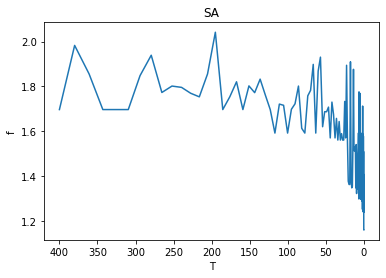

[119.   0. 469.   0. 294. 875. 875. 707. 630. 854. 476.   0. 119. 315.
 434. 252. 756.   0.   0. 476. 679. 119. 742. 497. 119. 182. 756. 497.
 315. 637. 756. 119. 924.]
[ 133.    0. 1134.  378. 1134.  630.  133.  833. 1155. 1036.  273.  427.
  616.  763.  413.  413.  532. 1113.  763.  133.    0.    0.  273.  742.
  385.  763.  651.  875.  616.  413.  413.  266. 1155.]


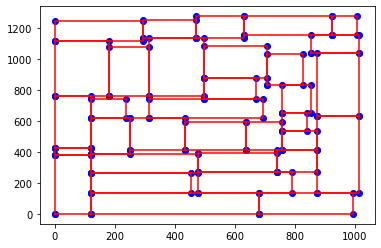

,square,utilization,timecost
0,1366414.0,0.846339,2604.786092
1,1479359.0,0.781723,2594.674096
2,1384250.0,0.835434,2583.452090
3,1416051.0,0.816672,2596.987022
4,1455300.0,0.794646,2592.025363
5,1435798.0,0.805440,2584.526998
6,1481760.0,0.780456,2600.695268
7,1426194.0,0.810864,2616.026165
8,1447264.0,0.799059,2599.227969
9,1402184.0,0.824748,2601.557200


In [65]:
print("本次测试的退火环境为：")
print(sa.iter,sa.T0,sa.alpha)
squ = []
use = []
for i in range(len(mmm)):
    squ.append(mmm[i].s_cur)
    use.append(mmm[i].use)
print(use)
index = use.index(max(use))
history = {'f': fff[index], 'T': TTT[index]}
print('本次最优解为：'+str(max(use)))
draw(history)

drawP(mmm[index])

wrXSLX(squ,use,sss,'result_standard.xlsx')